# Random Sampling with SciPy and NumPy: Part I

## Intro to sampling, writing our own, speed testing

Being able to draw a random sample from a distribution of your choice is very useful. It underlies any kind of stochastic process simulation whether that's particle diffusion, stock price movements or modelling any phenomena that displays some kind of randomness through time.

For that reason, having access to accurate and efficient sampling processes is very important. The importance only increases once we get to distributions that are used here, there and everywhere like the normal distribution.

The following is a 'deep dive' into how SciPy and NumPy package this up for us to make large scale sampling blazing fast and easy to use. Anyone with a bit of history using SciPy will tell you that the reason is the following:
 - it's written by some very clever people
 - it's very optimised code
 - it uses underlying numerical routines written in C

which is all true. The aim here is to go a bit further into exactly how this happens and why smart people can make things go faster with some clever algorithms.

## Why should I care what happens 'under the hood'?

Because SciPy can only get us so far, even though [the range of distributions it offers is quite incredible](https://docs.scipy.org/doc/scipy/reference/stats.html). The problem lies when we want to sample from 'custom distributions'. What if instead of sampling from a given parameterised normal or exponential distribution we want to start sampling from our own distribution? Maybe because this distribution better represents the data we are trying to fit and we'd like to leverage a Monte Carlo process for some testing?

In these situations as we'll see below it pays to understand how it works because:
 - writing your own naive sampling mechanism can be incredibly slow
 - understanding how it works can allow us to write our own custom distribution _within_ the SciPy framework

## How does sampling work?

Rephrasing: given a density function (pdf), how can I use this to draw random samples which if I were to plot them they would form a histogram the same shape as the pdf? To add a bit of visuals to this statement let's use the example of a normal distribution. Using SciPy let's plot the pdf and then generate a load of random samples - before getting into the nitty gritty of:
 - how it is generating these samples
 - how it does it so fast

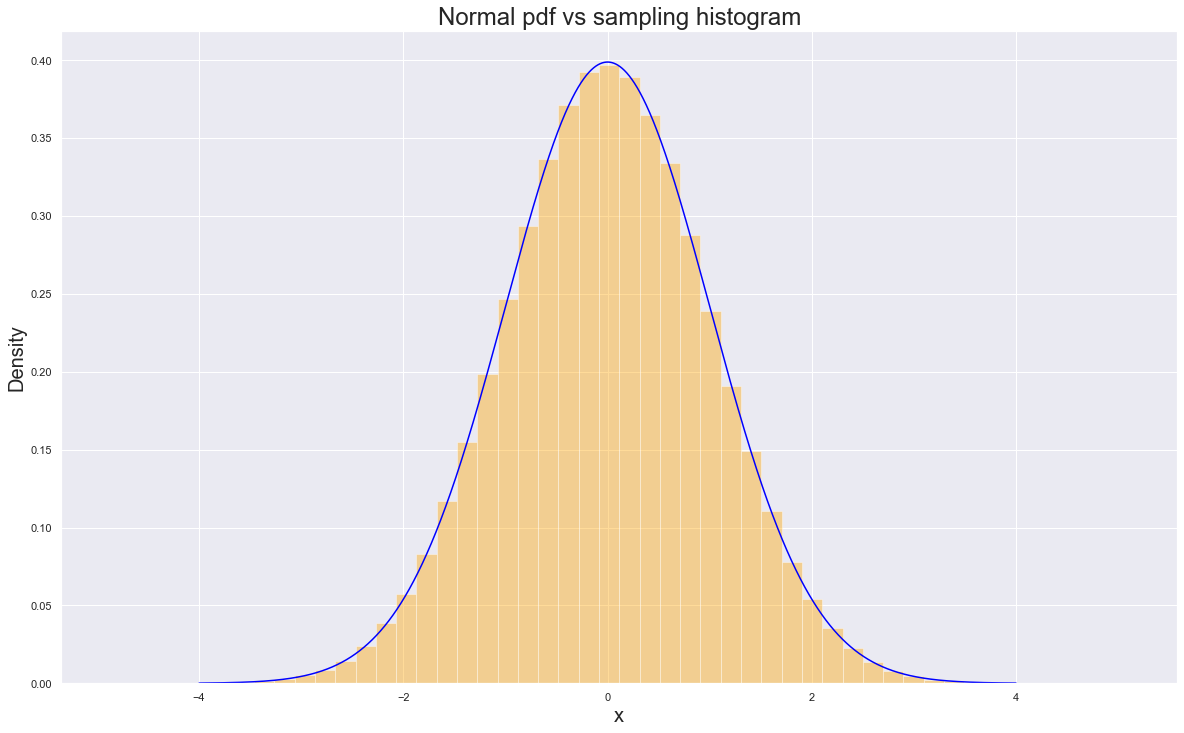

In [1]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set()

# create dist
snorm = stats.norm()
# create x's
xs = np.linspace(-4, 4, 100001)
# create pdfs
pdfs = snorm.pdf(xs)
# create random samples
n = 1000000
samps = snorm.rvs(size=n)
# plot them
fig, ax = plt.subplots(figsize=(20, 12))
sns.distplot(samps, kde=False, norm_hist=True, color='Orange', ax=ax)
ax.plot(xs, pdfs, color='Blue')
# label them
ax.set_title('Normal pdf vs sampling histogram', fontsize=24)
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('Density', fontsize=20);

So the blue line shows our plotted pdf and the orange histogram shows the histogram of the `1,000,000` samples that we drew from the same distribution. __This is sampling - given a specified blue line (whatever shape it may take), how can we define a process (preferably fast and accurate) that can generate numbers that form a histogram that agrees with the blue line.__

To answer the original question of _how_ we do this, the answer is: it depends. There are many ways to do this and each of these methods have advantages and disadvantages. As we'll find out some of these methods are much faster than others. To begin with we'll focus on one specific method that is general in its approach and that we'll use as the baseline for comparing the speed of SciPy. We can't call SciPy fast if we have nothing to compare it to.

## Inverse Transform Sampling (ITS)

There are a few ideas here that we'll try and condense down into several short paragraphs before writing some basic code to illustrate and form our speed benchmark. To start with we'll address the following - __generating random numbers requires some kind of random number generator__.

Regardless of the distribution we want to get them from we need some sort of underlying random process. In the case of computers, this process can't really be _truly_ random as it needs to be able to be programmed into a machine, but they can be 'pseudo' random.

In other words, if we don't know the underlying process that is generating the numbers then they can appear random to us even if they are not random to the generating process. To borrow from Nassim Taleb, what's random to the turkey on Christmas day isn't random to the farmer - it all depends on your information set. Such a process is called a pseudo-random number generator (PRNG) and there are lots of competing ones on offer.

Let's just take it for granted that we have such a PRNG that generates these random numbers and that these random numbers are from a uniform distribution. If you are curious about how exactly these numbers are created then I've written an explainer [here](https://towardsdatascience.com/where-does-python-get-its-random-numbers-from-81dece23b712), but for this article it will suffice to say that such a process exists.

Once we have those uniformly distributed numbers we then need a way to _transform_ them into the numbers that abide by the pdf that we specify (the blue line above). To do this we can make use of the [following theorem](https://en.wikipedia.org/wiki/Probability_integral_transform). It turns out that if we:
 - sample a load of numbers from a continuous probability distribution
 - get the value of the cdf for all of these samples

__the distribution of those cdf values will be uniformly distributed.__ To see this there's a great gif [here](https://gfycat.com/unfitflatflounder) that shows this process for a standard normal distribution. But more useful to us is the reverse - or the _inverse_. If we start with a load of uniformly distributed random numbers (which our PRNG will give us), then we can fire them at the 'inverse' cdf and obtain a load of numbers that follow the distribution that we wanted. This is what inverse transform sampling is.

## Can we code this up?

Absolutely. Writing this down and creating our own normal distribution random sampler will serve two purposes:
 - provide a code analogue to the above theoretical explanation
 - create a pure python comparison for the SciPy implementation to check speed

First let's define our pdf. We won't give SciPy too much of an advantage so to keep things reasonably fast we'll:
 - leverage NumPy for vectorised calculations
 - encode `sqrt(2 * pi)` as a float to save on the multiply and sqrt operations

In [2]:
# define std normal pdf
def norm_p(x):
    return np.exp(-0.5 * x**2) / 2.5066282746310002

Next we need to create the cdf so we can invert it. To do that we'll:
 - define a range of values and compute the pdf at each of these values
 - normalise the pdf values so we have a density function i.e. the area under the pdf will be `1`
 - use the 'cumulative' in 'cumulative distribution function' to create the cdf: we simply apply a cumulative sum to these pdf values to create our cdf

The following code implements this and just for good measure we'll graph both the created pdf and cdf for inspection.

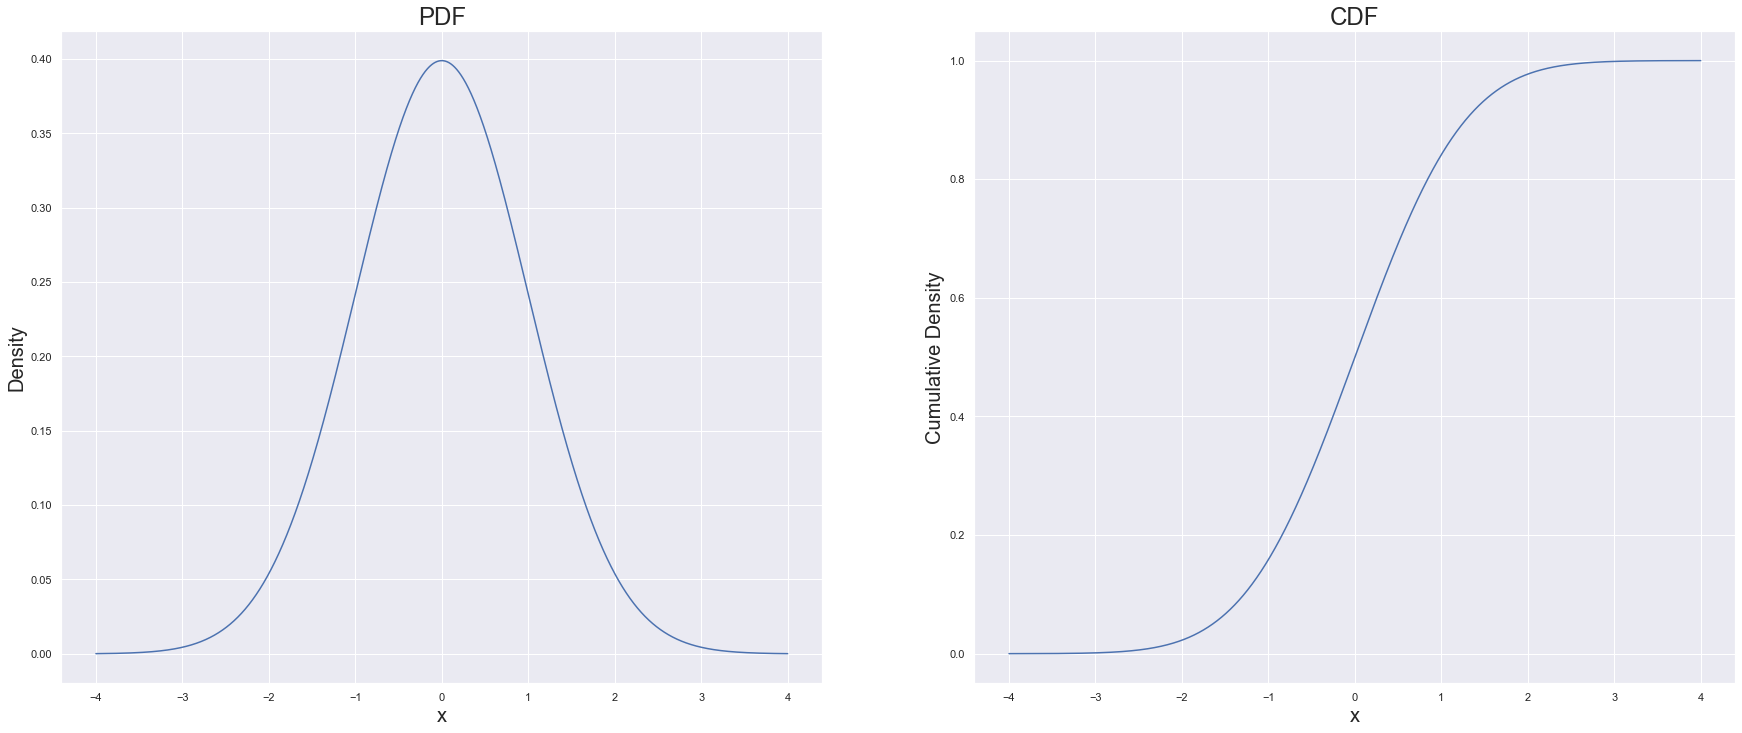

In [3]:
from scipy.interpolate import interp1d
from scipy.integrate import simps

# define function to normalise the PDF over chosen domain
def normalisation(x):
	return simps(norm_p(x), x)

# define x's
xs = np.linspace(-25, 25, 10000001)

# define function to normalise our pdf to sum to 1 so it satisfies a distribution
norm_constant = normalisation(xs)
# create pdf
my_pdfs = norm_p(xs) / norm_constant
# create cdf then ensure it is bounded at [0,1]
my_cdf = np.cumsum(my_pdfs)
my_cdf = my_cdf / my_cdf[-1]

# plot
fig, axes = plt.subplots(ncols=2, figsize=(30, 12))
axes = axes.reshape(-1)

# get index bounds
stds = 4
lower = int(len(xs) // 2 - ((len(xs)-1) / 50)*stds)
upper = int(len(xs) // 2 + ((len(xs)-1) / 50)*stds)

#plot pdf
axes[0].plot(xs[lower: upper], my_pdfs[lower: upper])
axes[0].set_title('PDF', fontsize=24)
axes[0].set_xlabel('x', fontsize=20)
axes[0].set_ylabel('Density', fontsize=20)
#plot cdf
axes[1].plot(xs[lower: upper], my_cdf[lower: upper])
axes[1].set_title('CDF', fontsize=24)
axes[1].set_xlabel('x', fontsize=20)
axes[1].set_ylabel('Cumulative Density', fontsize=20);

So it looks as expected. Now we need to take the generated cdf - which at this point is just a set of values of the cumulative probability for a set of x values and turn that into a function. In particular we would like to turn it into the inverse function. Fortunately for us we can rely on SciPy and use the interpolation function `interp1d`:

In [4]:
# generate the inverse cdf
func_ppf = interp1d(my_cdf, xs, fill_value='extrapolate')

We've called it a 'ppf' - percentage point function as this is consistent with the SciPy terminology but this is exactly what we wanted to achieve - an inverse cdf function. Now we have this function we can use it to:
 - first: fire uniformly distributed random numbers at it to generate samples from a standard normal distribution
 - second: compare how fast it does this compared to the built in SciPy sampling

## Distribution check

First let's double check to ensure we are generating numbers according to the correct distribution - in other words that I haven't lumped a bug into the above few lines of code. As mentioned, now that we have our inverse cdf we just need to fire random uniformly distributed numbers at it. How do we obtain those uniformly distributed random numbers?

Let's make use of the random number generator in NumPy:

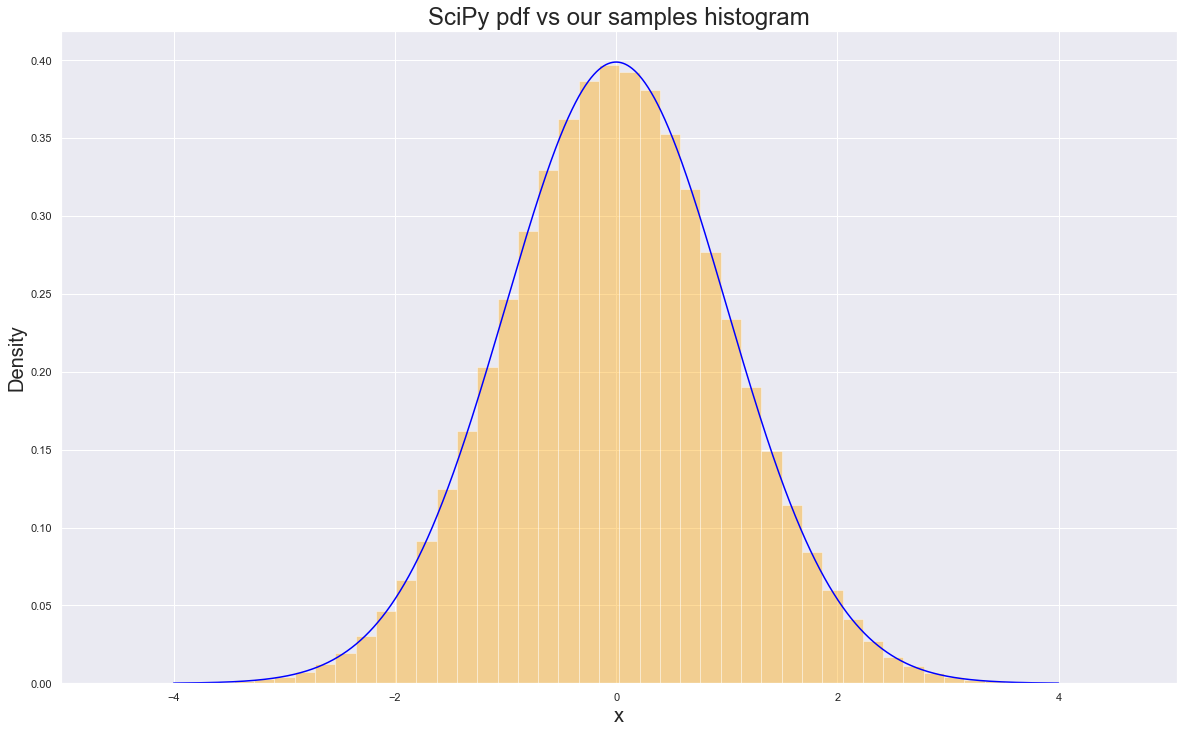

In [5]:
# define n
n = 1000000
# generate our samps
our_samps = func_ppf(np.random.uniform(size=n))
# generate comparison pdf from SciPy
xs = np.linspace(-4, 4, 1000001)
scipy_pdf = snorm.pdf(xs)

# plot
fig, ax = plt.subplots(figsize=(20, 12))
sns.distplot(our_samps, kde=False, norm_hist=True, color='Orange', ax=ax)
ax.plot(xs, scipy_pdf, color='Blue')
# label them
ax.set_title('SciPy pdf vs our samples histogram', fontsize=24)
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('Density', fontsize=20);

So we can be confident that the function we created does indeed draw random samples from a standard normal distribution - our orange histogram lines up with the SciPy generated blue line representing the pdf.

## Speed

Now on to the main question - how does the function we have generated compare to SciPy?

In [6]:
%timeit func_ppf(np.random.uniform(size=n))

2.32 s ± 264 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit snorm.rvs(size=n)

56.3 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So even though we've done our best to create an efficient implementation of a normal distribution sampler we're still `41x` slower than SciPy doing the same thing. This begs the next question: why?

## Recap

Before ploughing into the SciPy and NumPy code bases to figure out why we're still being left for dead when it comes to speed, let's just briefly recap what we've established:
 - sampling is the process of drawing random numbers that as a collection abide by a given pdf
 - there are many ways to implement this sampling - one such way is called Inverse Transform Sampling
 - ITS relies on inverting the cdf of a given distribution before plugging in uniformly distributed random numbers to it
 - even with a fairly efficient self-implementation of this we are around `40x` slower than SciPy

With that in mind, let's move on to digging through the SciPy and NumPy code bases.